# An analysis of sex ratios using a biodiversity data cube from GBIF data

This notebook was created for analysing GBIF download https://www.gbif.org/occurrence/download/0083528-240321170329656
Date 2 April 2024
Occurrences 4,038,527
Involved datasets 4,985
Involved publishers 230

Note: This select ignores ```dwc:individualCount``` in the record. It treats each record as an individual.
In the future it

``` SELECT "year", gbif_eeargCode(10000, decimalLatitude, decimalLongitude, COALESCE(coordinateUncertaintyInMeters, 10000)) AS eeaCellCode, speciesKey, COUNT(*) AS 'count', SUM(CASE WHEN sex = 'FEMALE' THEN 1 ELSE 0 END) AS female_count, SUM(CASE WHEN sex = 'MALE' THEN 1 ELSE 0 END) AS male_count, SUM(CASE WHEN sex = 'HERMERMAPHRODITE' THEN 1 ELSE 0 END) AS hermaphrodite_count, MIN(COALESCE(coordinateUncertaintyInMeters, 10000)) AS minCoordinateUncertaintyInMeters FROM occurrence WHERE occurrenceStatus = 'PRESENT' AND familyKey = 2986 AND NOT array_contains(issue, 'ZERO_COORDINATE') AND NOT array_contains(issue, 'COORDINATE_OUT_OF_RANGE') AND NOT array_contains(issue, 'COORDINATE_INVALID') AND NOT array_contains(issue, 'COUNTRY_COORDINATE_MISMATCH') AND (identificationVerificationStatus IS NULL OR NOT ( LOWER(identificationVerificationStatus) LIKE '%unverified%' OR LOWER(identificationVerificationStatus) LIKE '%unvalidated%' OR LOWER(identificationVerificationStatus) LIKE '%not able to validate%' OR LOWER(identificationVerificationStatus) LIKE '%control could not be conclusive due to insufficient knowledge%' OR LOWER(identificationVerificationStatus) LIKE '%unconfirmed%' OR LOWER(identificationVerificationStatus) LIKE '%unconfirmed - not reviewed%' OR LOWER(identificationVerificationStatus) LIKE '%validation requested%' ) ) AND "year" >= 1900 AND continent = 'EUROPE' AND hasCoordinate GROUP BY "year", eeaCellCode, speciesKey ORDER BY "year" DESC, eeaCellCode ASC, speciesKey ASC; ```

In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
import seaborn as sns
from shapely.geometry import Polygon
import requests
import sys

In [2]:
# Read the file, assuming it's tab-separated and the first row contains column names
file_path = '0083528-240321170329656.csv'   
df = pd.read_csv(file_path, sep='\t')

In [3]:
#Splits the 'eeacellcode' column into three new columns ('resolution', 'long', 'lat')
#    with four characters in each and adds them to the DataFrame.
#
#    Parameters:
#    - df: The original DataFrame containing the 'eeacellcode' column.
#
#    Returns:
#    - df: The modified DataFrame with the new columns added.
#    """
# Check if 'eeacellcode' column exists in the DataFrame
if 'eeacellcode' in df.columns:
     # Splitting the 'eeacellcode' column into three new columns
     df['resolution'] = df['eeacellcode'].str[:4]
     df['long'] = df['eeacellcode'].str[4:8]
     df['lat'] = df['eeacellcode'].str[8:12]
else:
     print("The column 'eeacellcode' does not exist in the DataFrame.")

In [4]:
df = df.dropna()

In [5]:
# Remove the first character from 'long' and 'lat' columns and create new 'longitude' and 'latitude' columns
df['longitude'] = df['long'].str[1:]

In [6]:
df['latitude'] = df['lat'].str[1:]

In [7]:
df['longitude'] = pd.to_numeric(df['longitude'], downcast='float') * 10000
df['latitude'] = pd.to_numeric(df['latitude'], downcast='float') * 10000

In [8]:
# Print the first few rows of the DataFrame to verify the new columns
print(df.head(10))

    year   eeacellcode  specieskey  count  female_count  male_count  \
25  2024  10kmE263N192   8332393.0      1             0           0   
26  2024  10kmE263N195   9751099.0      1             0           0   
27  2024  10kmE264N191   8332393.0      1             0           0   
28  2024  10kmE264N191   9362027.0      1             0           0   
29  2024  10kmE264N192   9362027.0      1             0           0   
30  2024  10kmE264N194   8332393.0      1             0           0   
31  2024  10kmE264N194   9761484.0      1             0           0   
32  2024  10kmE264N195   2498252.0      1             0           0   
33  2024  10kmE264N195   2498343.0      1             0           0   
34  2024  10kmE264N195   9751099.0      1             0           0   

    hermaphrodite_count  mincoordinateuncertaintyinmeters resolution  long  \
25                    0                           28240.0       10km  E263   
26                    0                           10000.0     

In [9]:
# Convert 'longitude' and 'latitude' to numeric types, if they're not already
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')

# Create a new GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Set the coordinate reference system (CRS) to ETRS89-LAEA Europe (EPSG:3035) for latitude and longitude
gdf.crs = "EPSG:3035"

# Now 'gdf' is a GeoDataFrame with a 'geometry' column holding spatial data

# Example: Save this GeoDataFrame to a shapefile
# gdf.to_file("species_locations.shp")

print(gdf.head())


    year   eeacellcode  specieskey  count  female_count  male_count  \
25  2024  10kmE263N192   8332393.0      1             0           0   
26  2024  10kmE263N195   9751099.0      1             0           0   
27  2024  10kmE264N191   8332393.0      1             0           0   
28  2024  10kmE264N191   9362027.0      1             0           0   
29  2024  10kmE264N192   9362027.0      1             0           0   

    hermaphrodite_count  mincoordinateuncertaintyinmeters resolution  long  \
25                    0                           28240.0       10km  E263   
26                    0                           10000.0       10km  E263   
27                    0                           28240.0       10km  E264   
28                    0                           28240.0       10km  E264   
29                    0                           28240.0       10km  E264   

     lat  longitude   latitude                         geometry  
25  N192  2630000.0  1920000.0  POINT 

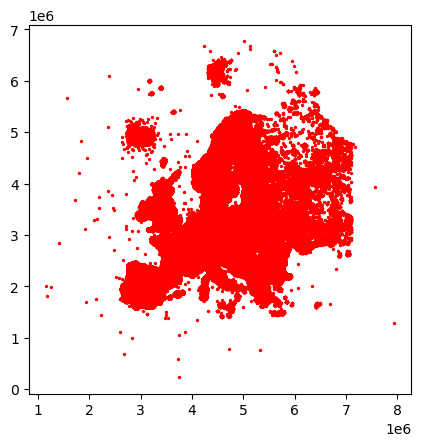

In [10]:
# Basic plot
gdf.plot(marker='o', color='red', markersize=2)
plt.show()


In [11]:
# Assuming your GeoDataFrame is named gdf

# Group by 'specieskey' and aggregate the counts
# The geometry is not directly involved in the aggregation here
result = gdf.groupby('specieskey').agg({
    'count': 'sum',  # Summing up female counts
    'female_count': 'sum',  # Summing up female counts
    'male_count': 'sum',    # Summing up male counts
}).reset_index()

# If you want to perform more sophisticated spatial aggregations, you might need to use .dissolve() or custom functions.

print(result)

     specieskey  count  female_count  male_count
0     2497999.0      1             0           0
1     2498001.0     47             2           0
2     2498003.0      5             0           0
3     2498007.0    113             7          11
4     2498008.0      1             0           0
..          ...    ...           ...         ...
187  11207273.0     31             0           0
188  11792185.0      1             0           1
189  12238265.0     59             0           0
190  12251645.0      4             0           1
191  12258117.0      1             0           1

[192 rows x 4 columns]


In [12]:
# First, calculate the proportion for each row
result['proportion'] = (result['female_count'] + result['male_count']) / result['count']

# Then, find the row with the maximum proportion
max_prop_row = result.loc[result['proportion'].idxmax()]

# Print out the specieskey and the maximum proportion
print(f"Species Key with highest proportion: {max_prop_row['specieskey']}")
print(f"Maximum proportion: {max_prop_row['proportion']}")

Species Key with highest proportion: 2498040.0
Maximum proportion: 1.0


In [13]:
# Define the function to get species Latin name by speciesKey
def get_species_names(speciesKey):
    # Convert speciesKey to integer to remove the '.0'
    speciesKey = int(speciesKey)
    url = f"https://api.gbif.org/v1/species/{speciesKey}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        latin_name = data.get('scientificName')
        vernacular_name = data.get('vernacularName', 'N/A')  # Default to 'N/A' if not available
        return latin_name, vernacular_name
    else:
        print(f"Failed to retrieve data for speciesKey {speciesKey}. Status code: {response.status_code}")
        return None, None

# Function to append Latin names to your DataFrame
def append_names(df):
    # Create new columns for the Latin and vernacular names
    names = df['specieskey'].apply(lambda x: get_species_names(x))
    df['latin_name'] = names.apply(lambda x: x[0])
    df['vernacular_name'] = names.apply(lambda x: x[1])
    return df

In [14]:
# Step 1: Sort the DataFrame by the 'proportion' column in descending order
sorted_gdf = result.sort_values(by='proportion', ascending=False)

# Filter the DataFrame to include only rows where 'count' > 10000
filtered_result = sorted_gdf[sorted_gdf['count'] > 10000].copy()

filtered_result_with_names = append_names(filtered_result)

# Step 2: Select the top ten entries
top_ = filtered_result.head(5).copy()

# Step 3: Select the bottom ten entries
# Option A: Sort in ascending order and take the top ten
bottom_ = filtered_result.sort_values(by='proportion', ascending=True).head(5).copy()

# Apply the function to both top ten and bottom ten DataFrames
top_ten_with_names = append_names(top_)
bottom_ten_with_names = append_names(bottom_)


# Display the results
print("Top species by proportion:")
print(top_[['specieskey', 'count', 'proportion', 'latin_name', 'vernacular_name']])

print("\nBottom species by proportion:")
print(bottom_[['specieskey', 'count', 'proportion', 'latin_name', 'vernacular_name']])


Top species by proportion:
     specieskey  count  proportion                              latin_name  \
82    2498350.0  33654    0.488649  Somateria spectabilis (Linnaeus, 1758)   
105   5232431.0  11861    0.405278      Polysticta stelleri (Pallas, 1769)   
33    2498125.0  11056    0.374457      Anas carolinensis J.F.Gmelin, 1789   
36    2498155.0  10457    0.281534     Mareca americana (J.F.Gmelin, 1789)   
60    2498264.0  20277    0.266854         Aythya collaris (Donovan, 1809)   

       vernacular_name  
82          King Eider  
105    Steller's Eider  
33   Green-winged Teal  
36     American Wigeon  
60    Ring-necked Duck  

Bottom species by proportion:
     specieskey   count  proportion                           latin_name  \
10    2498024.0  269082    0.000691   Anser brachyrhynchus Baillon, 1834   
111   5232451.0   45531    0.000857     Branta ruficollis (Pallas, 1769)   
40    2498167.0   22508    0.001066  Anser caerulescens (Linnaeus, 1758)   
158  10124612.0   1

In [15]:
num_rows = len(filtered_result)
print("Number of ducks:", num_rows)
filtered_result_with_names.to_csv('high_species_counts.csv', index=False)

Number of ducks: 54


In [16]:
# Step 1: Calculate the start year of the decade for each row and create a new 'decade' column
gdf['decade'] = (gdf['year'] // 10) * 10

In [17]:
gdf['geometry_wkt'] = gdf['geometry'].apply(lambda x: x.wkt)

In [18]:
# Grouping the DataFrame by 'eeacellcode' and 'specieskey'
grouped_df = gdf.groupby(['decade','eeacellcode', 'specieskey', 'long', 'lat', 'longitude', 'latitude','geometry_wkt'])[['count', 'female_count', 'male_count']].sum().reset_index()


In [19]:
#print(grouped_df.head(1))
print(grouped_df.describe())

             decade    specieskey     longitude      latitude         count  \
count  1.476502e+06  1.476502e+06  1.476502e+06  1.476502e+06  1.476502e+06   
mean   2.003892e+03  4.942655e+06  4.240124e+06  3.424666e+06  2.421870e+01   
std    1.680429e+01  3.071132e+06  7.503707e+05  8.228844e+05  1.345226e+02   
min    1.900000e+03  2.497999e+06  1.160000e+06  2.300000e+05  1.000000e+00   
25%    2.000000e+03  2.498255e+06  3.630000e+06  2.860000e+06  1.000000e+00   
50%    2.010000e+03  2.498347e+06  4.260000e+06  3.370000e+06  2.000000e+00   
75%    2.020000e+03  8.214667e+06  4.730000e+06  4.010000e+06  8.000000e+00   
max    2.020000e+03  1.225812e+07  7.930000e+06  6.770000e+06  1.719800e+04   

       female_count    male_count  
count  1.476502e+06  1.476502e+06  
mean   5.334270e-01  7.615987e-01  
std    1.402021e+01  1.186829e+01  
min    0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  
50%    0.000000e+00  0.000000e+00  
75%    0.000000e+00  0.000000e+00  


In [20]:
# Set the coordinate reference system (CRS) to ETRS89-LAEA Europe (EPSG:3035) for latitude and longitude
grouped_df.crs = "EPSG:3035"

In [21]:
print(grouped_df.crs)

EPSG:3035


In [22]:
grouped_df['geometry'] = grouped_df['geometry_wkt'].apply(wkt.loads)

# Convert to a GeoDataFrame
ggdf = gpd.GeoDataFrame(grouped_df, geometry='geometry')

In [175]:
duckkey = input("Enter the taxon key of a European duck from GBIF (default: Anas platyrhynchos = 9761484): ")

# Check if the input is empty
if not duckkey.strip():
    # Set default value if input is empty
    duckkey = 9761484
    
duckkey = int(duckkey)

print(f"Your duck key is , {duckkey}!")



Enter the taxon key of a European duck from GBIF (default: Anas platyrhynchos = 9761484): 
Your duck key is , 9761484!


In [176]:
# Basic plot of Aythya fuligula (L., 1758) = 2498261
# Basic plot of Anas platyrhynchos Linnaeus, 1758 = 9761484

# Select rows where the 'specieskey' column matches the specific_specieskey
filtered_gdf = ggdf[ggdf['specieskey'] == duckkey].copy()
# Set the coordinate reference system (CRS) to ETRS89-LAEA Europe (EPSG:3035) for latitude and longitude
filtered_gdf.crs = "EPSG:3035"

In [177]:
columns = grouped_df.columns
print(columns)

Index(['decade', 'eeacellcode', 'specieskey', 'long', 'lat', 'longitude',
       'latitude', 'geometry_wkt', 'count', 'female_count', 'male_count',
       'geometry'],
      dtype='object')


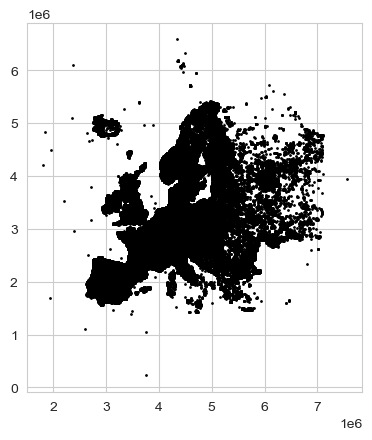

In [178]:
filtered_gdf.plot(marker='o', color='black', markersize=1)
plt.show()

In [179]:
# Remove rows where both 'female_count' and 'male_count' are zero, and 'eeacellcode' is NaN
filtered_gdf = filtered_gdf[(filtered_gdf['female_count'] > 1) | (filtered_gdf['male_count'] > 1)]

In [180]:
# Ensure there's no division by zero
#filtered_gdf['male_to_female_ratio'] = np.where(filtered_gdf['female_count'] > 0, filtered_gdf['male_count'] / (filtered_gdf['female_count'] + filtered_gdf['male_count']), np.nan)
#filtered_gdf['male_to_female_ratio'] = np.where(filtered_gdf['female_count'] > 0, (filtered_gdf['male_count'] / filtered_gdf['female_count'])*100, np.nan)


filtered_gdf['percentage_male'] = np.where(filtered_gdf['female_count'] > -1, 100*(filtered_gdf['male_count'] / (filtered_gdf['female_count'] + filtered_gdf['male_count'])), np.nan)


C:\Users\quent\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [181]:
# Print the resulting DataFrame to verify the rows have been removed
print(filtered_gdf.head(5))

     decade   eeacellcode  specieskey  long   lat  longitude   latitude  \
164    1900  10kmE306N501   9761484.0  E306  N501  3060000.0  5010000.0   
614    1900  10kmE350N365   9761484.0  E350  N365  3500000.0  3650000.0   
625    1900  10kmE351N366   9761484.0  E351  N366  3510000.0  3660000.0   
788    1900  10kmE394N323   9761484.0  E394  N323  3940000.0  3230000.0   
813    1900  10kmE395N305   9761484.0  E395  N305  3950000.0  3050000.0   

                geometry_wkt  count  female_count  male_count  \
164  POINT (3060000 5010000)      3             2           0   
614  POINT (3500000 3650000)      5             2           3   
625  POINT (3510000 3660000)      5             2           3   
788  POINT (3940000 3230000)      4             1           2   
813  POINT (3950000 3050000)      2             0           2   

                            geometry  percentage_male  
164  POINT (3060000.000 5010000.000)         0.000000  
614  POINT (3500000.000 3650000.000)        60

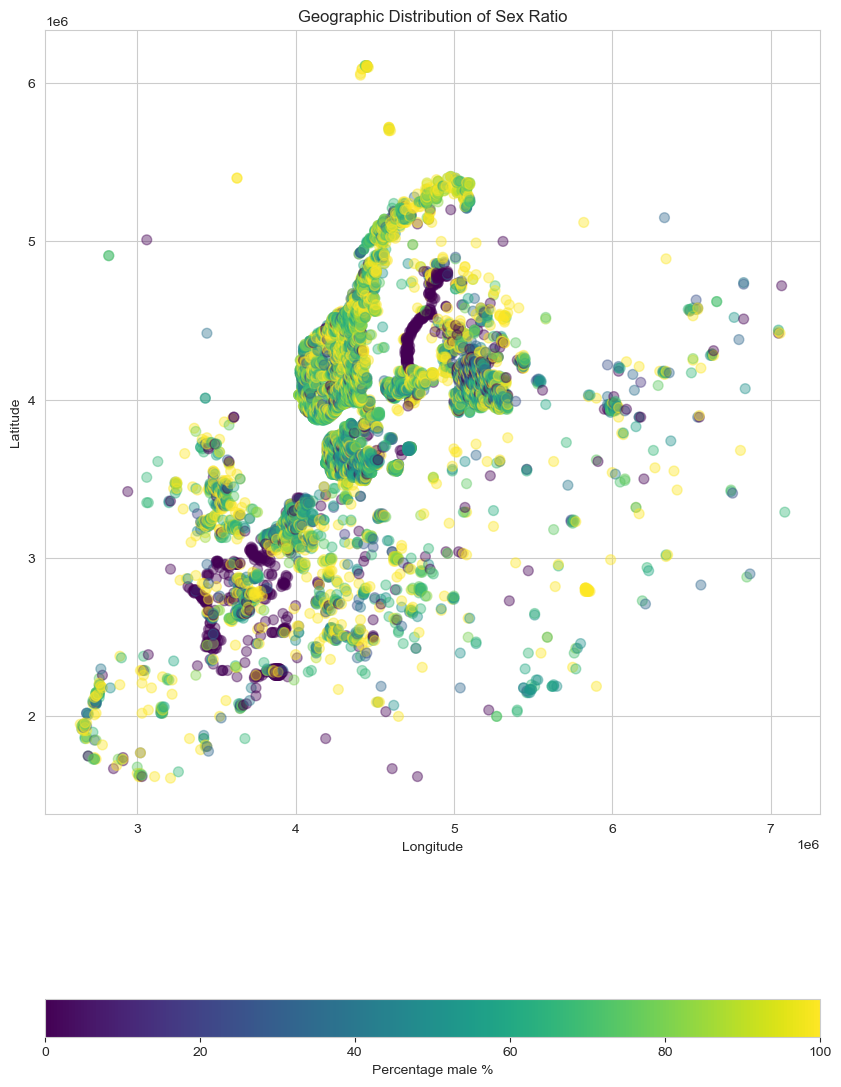

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(10, 16))

# Plot using the 'sex_ratio' column to color the points
filtered_gdf.plot(column='percentage_male', ax=ax, legend=True, 
         legend_kwds={'label': "Percentage male %", 'orientation': "horizontal"},
         cmap='viridis', markersize=50, alpha=0.4)  # Adjust 'markersize' and 'alpha' as needed

plt.title('Geographic Distribution of Sex Ratio')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [183]:
point_filtered_gdf = filtered_gdf.copy()

In [184]:
# Drop NaN values from your dataset
filtered_gdf = filtered_gdf.dropna(subset=['decade', 'percentage_male'])

# Also, ensure there are no infinite values
filtered_gdf = filtered_gdf.replace([np.inf, -np.inf], np.nan).dropna(subset=['decade', 'percentage_male'])

<Figure size 1200x600 with 0 Axes>

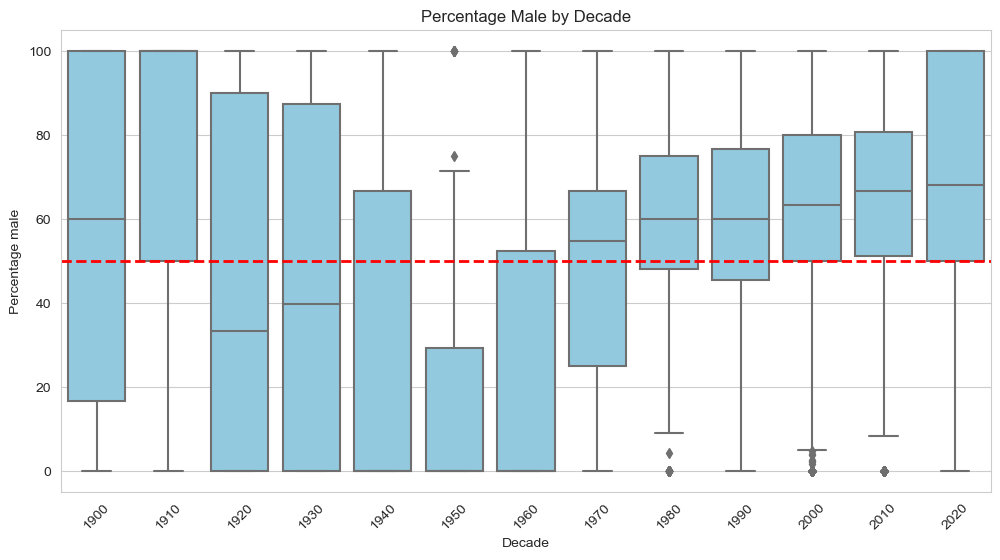

In [185]:
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(figsize=(12, 6))

# Create a box plot
sns.boxplot(x='decade', y='percentage_male', data=filtered_gdf, color='skyblue', ax=ax)

# Set the y-axis to a logarithmic scale
ax.set_yscale('linear')

# Adding a dotted horizontal line at 50%
ax.axhline(y=50, color='red', linestyle='--', linewidth=2, label='50% line')

plt.title('Percentage Male by Decade')
plt.xlabel('Decade')
plt.ylabel('Percentage male')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.savefig('ratiotimeseries.jpg', dpi=600, format='jpg')
plt.show()


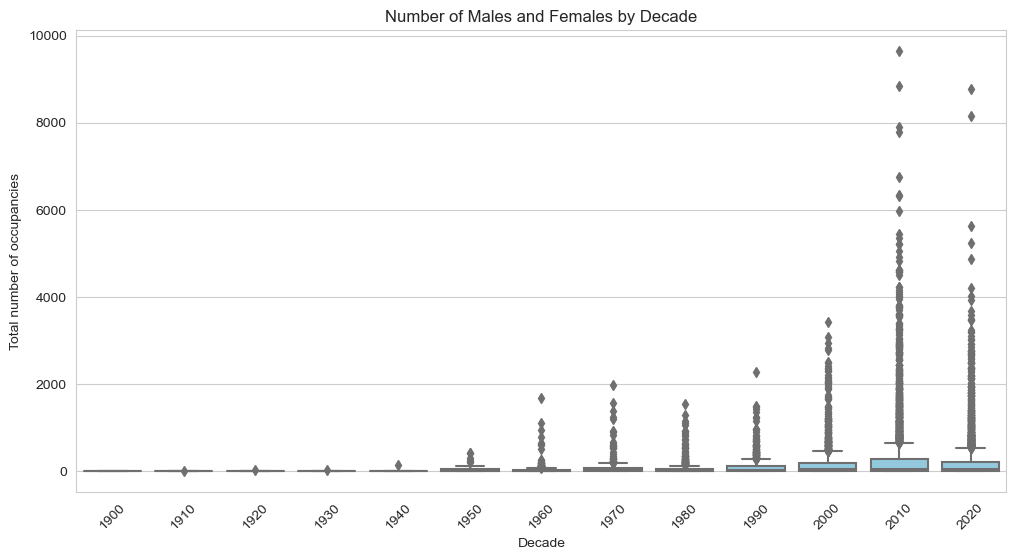

In [186]:
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))

# Set the y-axis to log scale
ax.set_yscale('linear')

# Create a box plot
sns.boxplot(x='decade', y='count', data=filtered_gdf, color='skyblue')

plt.title('Number of Males and Females by Decade')
plt.xlabel('Decade')
plt.ylabel('Total number of occupancies')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

plt.show()


In [187]:
# Convert GeoDataFrame to a regular DataFrame for the melting process
df = pd.DataFrame(gdf.drop(columns='geometry'))

aggregatedAllByDecade = df.groupby('decade')[['male_count', 'female_count']].sum().reset_index()

# Melting the DataFrame
df_melted = aggregatedAllByDecade.melt(id_vars=['decade'], value_vars=['male_count', 'female_count'],
                    var_name='Gender', value_name='Count')

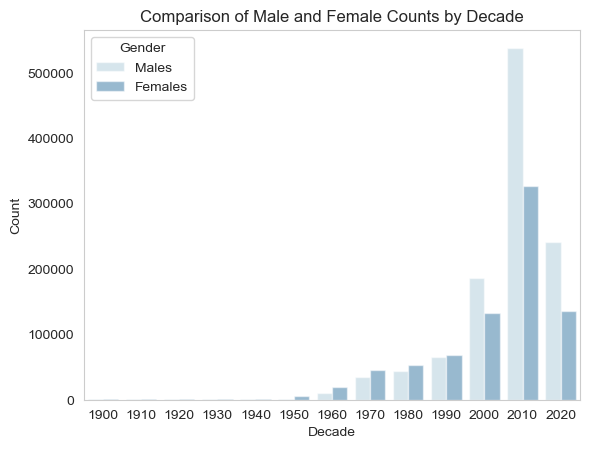

In [188]:
# Define a colorblind-safe palette
colors = sns.color_palette("Paired", 2)  # 'husl' is colorblind safe; adjust the number as needed for categories

# Creating the boxplot with seaborn
barplot = sns.barplot(x='decade', y='Count', hue='Gender', palette=colors, alpha=0.5, data=df_melted)

plt.title('Comparison of Male and Female Counts by Decade')
plt.xlabel('Decade')
plt.ylabel('Count')
plt.grid(axis='y')

# Modify the legend
leg = barplot.get_legend()
leg.set_title('Gender')
new_labels = ['Males', 'Females']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

plt.savefig('count.jpg', dpi=600, format='jpg')

plt.show()

In [189]:
from shapely.geometry import Polygon

def create_square_polygon_from_point(point, side_length=10000):
    """Create a square polygon with the given side length, using the point as the bottom-left corner."""
    if point is None:
        return None
    lower_left = point
    lower_right = (point.x + side_length, point.y)
    upper_right = (point.x + side_length, point.y + side_length)
    upper_left = (point.x, point.y + side_length)
    return Polygon([lower_left, lower_right, upper_right, upper_left, lower_left])


In [190]:
# Make sure your GeoDataFrame is in the correct CRS (EPSG:3035 or another meter-based CRS)
# If not, convert it: gdf = gdf.to_crs('EPSG:3035')

# Apply the function to create a new 'square_polygon' column
filtered_gdf['square_polygon'] = filtered_gdf['geometry'].apply(create_square_polygon_from_point)


In [191]:
filtered_gdf = filtered_gdf.set_geometry('square_polygon')

In [192]:
# Load the world map

# Country boundaries from https://www.naturalearthdata.com/downloads/50m-cultural-vectors/
path_to_shapefile = 'ne_50m_admin_0_countries.shp'

# Reading the shapefile
world = gpd.read_file(path_to_shapefile)

#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['CONTINENT'] == 'Europe']
europe = europe.to_crs(filtered_gdf.crs)

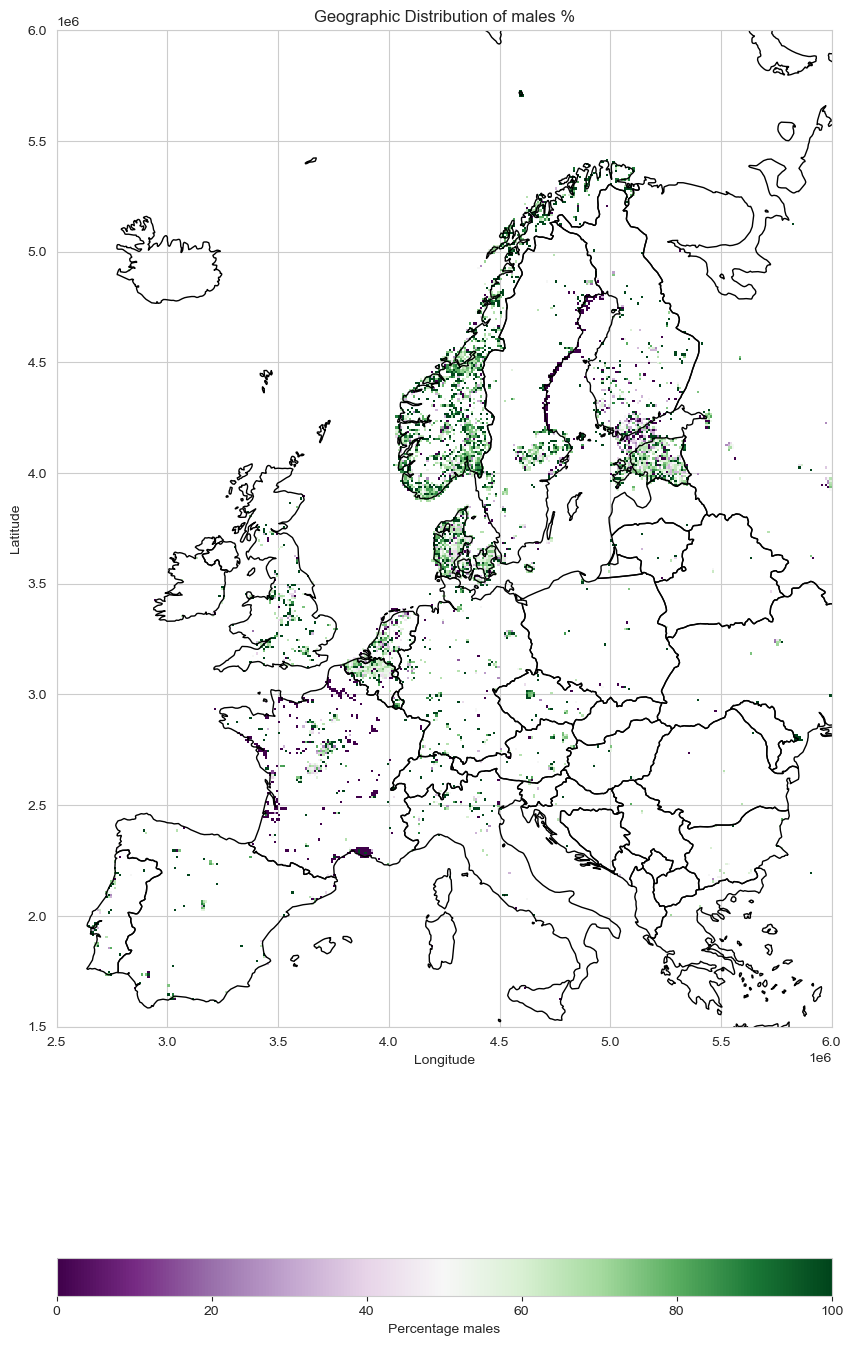

In [193]:
# Example bounds (you'll replace these with your desired bounds)
min_longitude, max_longitude = 2500000, 6000000  # Adjust these values to your desired longitude bounds
min_latitude, max_latitude = 1500000, 6000000    # Adjust these values to your desired latitude bounds

fig, ax = plt.subplots(1, 1, figsize=(10, 20))

# Plot using the 'sex_ratio' column to color the points
filtered_gdf.plot(edgecolor='none', column='percentage_male', ax=ax, legend=True, 
         legend_kwds={'label': "Percentage males", 'orientation': "horizontal"},
         cmap='PRGn', markersize=50, alpha=1)  # Adjust 'markersize' and 'alpha' as needed
europe.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Set the x and y limits to your desired bounds
ax.set_xlim(min_longitude, max_longitude)
ax.set_ylim(min_latitude, max_latitude)

plt.title('Geographic Distribution of males %')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the plot as a JPG file with 600 DPI (dots per inch), which is equivalent to PPI (pixels per inch)
plt.savefig('duckmap.jpg', dpi=600, format='jpg')

plt.show()

In [194]:
import scipy.stats as stats

# Sample data
data1 = [0.001291468238,0.004199160168,0.002007341133,0.001066287542,0.002871011662,0.01105410844,0.0008565592673,0.001613418262,0.003112752381,0.003772281699,0.007483962937,0.01484011628,0.006819157012,0.0006912391018,0.00133744634,0.01230220722,0.0201397288,0.002559040641,0.006447922514,0.002821320435,0.01208975746,0.00179451385,0.005027748521]  # smaller group, possibly different variance
data2 = [0.02366805308,0.2815339007,0.01658328701,0.3744573082,0.4052778012,0.1867275859,0.2668540711,0.02301060795,0.4886491947,0.09088860851,0.06736600041,0.1677511971,0.1705426802,0.0469681223,0.10189111,0.07264893775,0.2229428025,0.1459503601,0.0587223169,0.09038665354,0.1035862655,0.1673911549,0.07008879013,0.1775098736,0.07055780269,0.0449367491,0.1232377165,0.04633261258,0.05522279134,0.0534114146,0.05401061172]  # larger group, possibly different variance

# Calculate means
mean_data1 = np.mean(data1)
mean_data2 = np.mean(data2)

# Calculate standard deviations (sample standard deviation)
std_dev_data1 = np.std(data1, ddof=1)
std_dev_data2 = np.std(data2, ddof=1)

# Perform Welch's t-test
t_stat, p_value = stats.ttest_ind(data1, data2, equal_var=False)

print("t-statistic:", t_stat)
print("p-value:", p_value)

# Print the results
print("Mean of Data 1:", mean_data1)
print("Standard Deviation of Data 1:", std_dev_data1)
print("Mean of Data 2:", mean_data2)
print("Standard Deviation of Data 2:", std_dev_data2)

t-statistic: -6.207430028845702
p-value: 7.647812565876759e-07
Mean of Data 1: 0.005486893474091305
Standard Deviation of Data 1: 0.005232875166436826
Mean of Data 2: 0.13771310909064519
Standard Deviation of Data 2: 0.11844481902058987


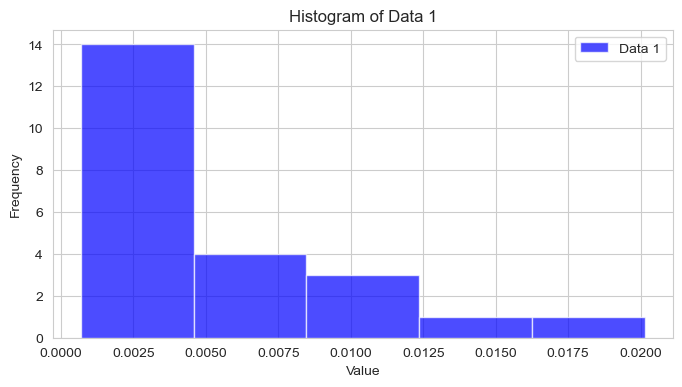

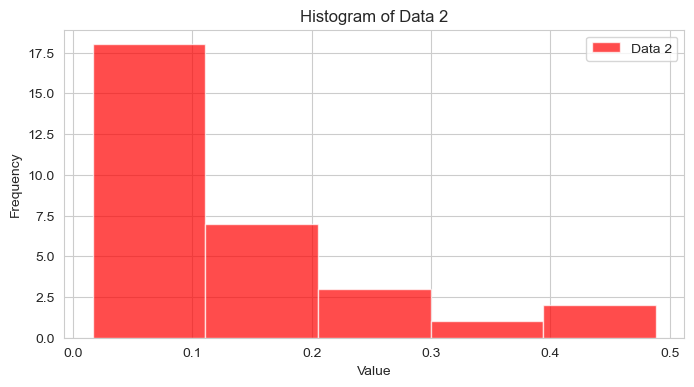

In [195]:
# Plot histogram for data1
plt.figure(figsize=(8, 4))  # Creates a new figure
plt.hist(data1, bins=5, color='blue', alpha=0.7, label='Data 1')  # Adjust 'bins' as necessary
plt.title('Histogram of Data 1')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot histogram for data2
plt.figure(figsize=(8, 4))  # Creates another new figure
plt.hist(data2, bins=5, color='red', alpha=0.7, label='Data 2')  # Adjust 'bins' as necessary
plt.title('Histogram of Data 2')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()



In [196]:
coordinates = np.array(list(point_filtered_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
values = point_filtered_gdf['percentage_male'].values

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'hole-effect' Variogram Model
Partial Sill: 783.6218111171382
Full Sill: 1043.1149282722565
Range: 3604733.86490242
Nugget: 259.49311715511834 



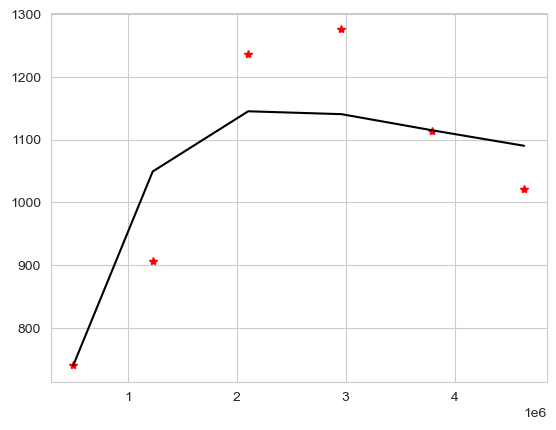

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [197]:
from pykrige.ok import OrdinaryKriging

# Create an Ordinary Kriging object with parameters
OK = OrdinaryKriging(
    coordinates[:, 0],  # X coordinates
    coordinates[:, 1],  # Y coordinates
    values,             # Data values
    variogram_model='hole-effect',  # Example variogram model
    verbose=True,       # For verbose output
    enable_plotting=True # For displaying variogram
)

# Define the grid size over which to interpolate
grid_x = np.linspace(coordinates[:, 0].min(), coordinates[:, 0].max(), num=100)
grid_y = np.linspace(coordinates[:, 1].min(), coordinates[:, 1].max(), num=100)

# Perform kriging to interpolate
z, ss = OK.execute('grid', grid_x, grid_y)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


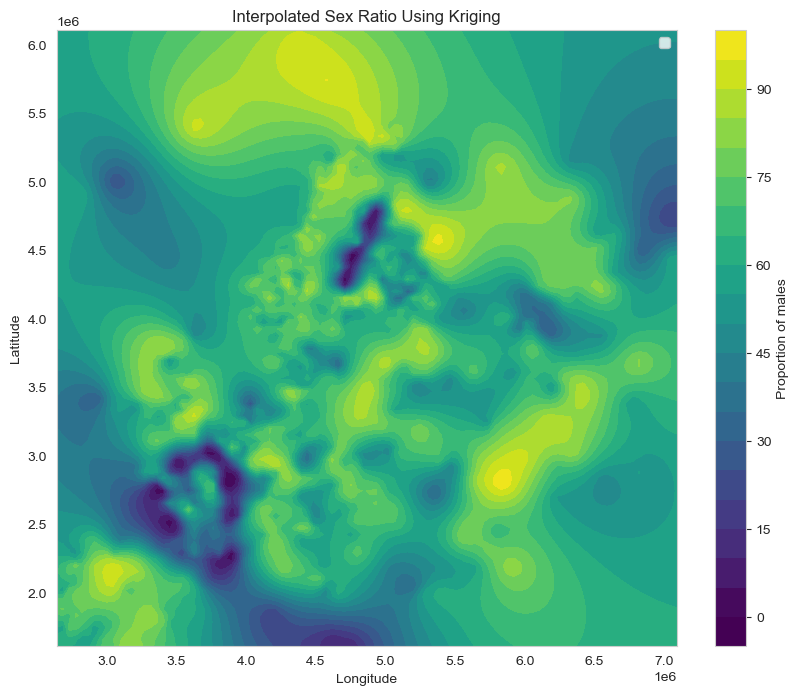

In [198]:
# Create a meshgrid for plotting
X, Y = np.meshgrid(grid_x, grid_y)

# Plotting the interpolated grid
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, z, cmap='viridis', levels=20, vmin=0, vmax=100)
plt.colorbar(label='Proportion of males')

#plt.scatter(coordinates[:, 0], coordinates[:, 1], c='red', label='Sample Points', norm=norm)
#europe.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
plt.legend()
plt.title('Interpolated Sex Ratio Using Kriging')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()


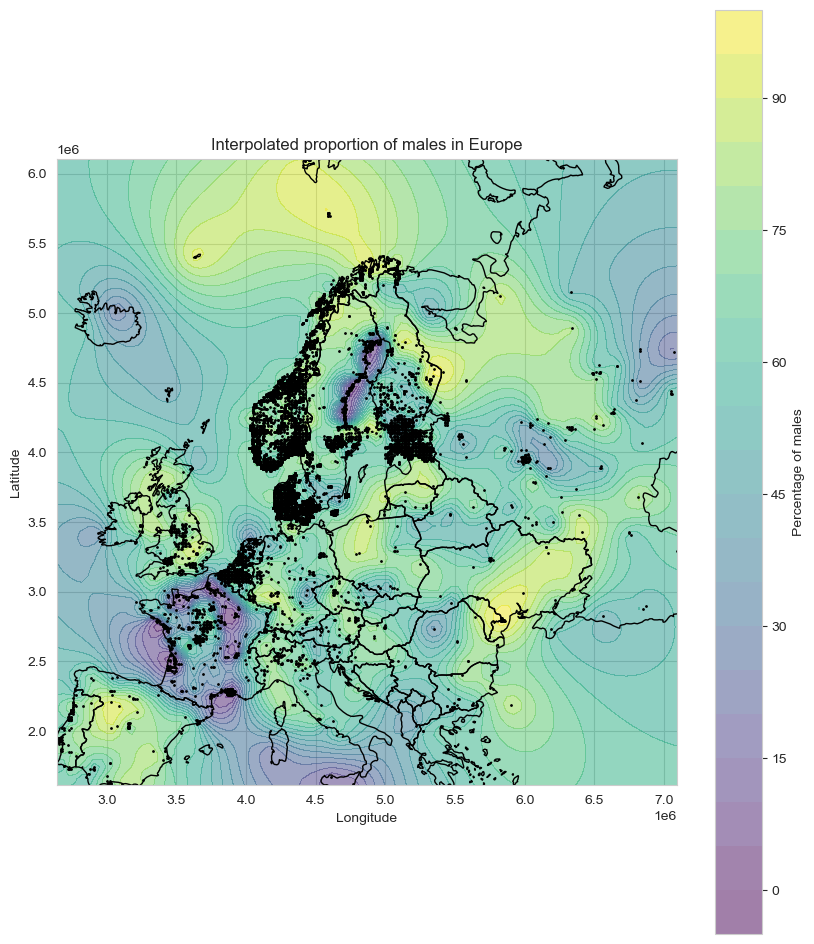

In [199]:
# Setup figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

# Plot interpolated sex ratio data
cf = ax.contourf(X, Y, z, cmap='viridis', alpha=0.5, levels=20, vmin=0, vmax=100)  # Using alpha for better visibility of borders

fig.colorbar(cf, ax=ax, label='Percentage of males')

plt.scatter(coordinates[:, 0], coordinates[:, 1], c='black', s=1, label='Sample Points')

# Plot European country borders
europe.boundary.plot(ax=ax, linewidth=1, edgecolor='k')

# Customize the plot
ax.set_title('Interpolated proportion of males in Europe')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Optionally set the limits for a closer view or to focus on a specific area
ax.set_xlim([X.min(), X.max()])
ax.set_ylim([Y.min(), Y.max()])

# Save the plot as a JPG file with 600 DPI (dots per inch), which is equivalent to PPI (pixels per inch)
plt.savefig('duckinterpolatedmap.jpg', dpi=600, format='jpg')

# Show the plot
plt.show()


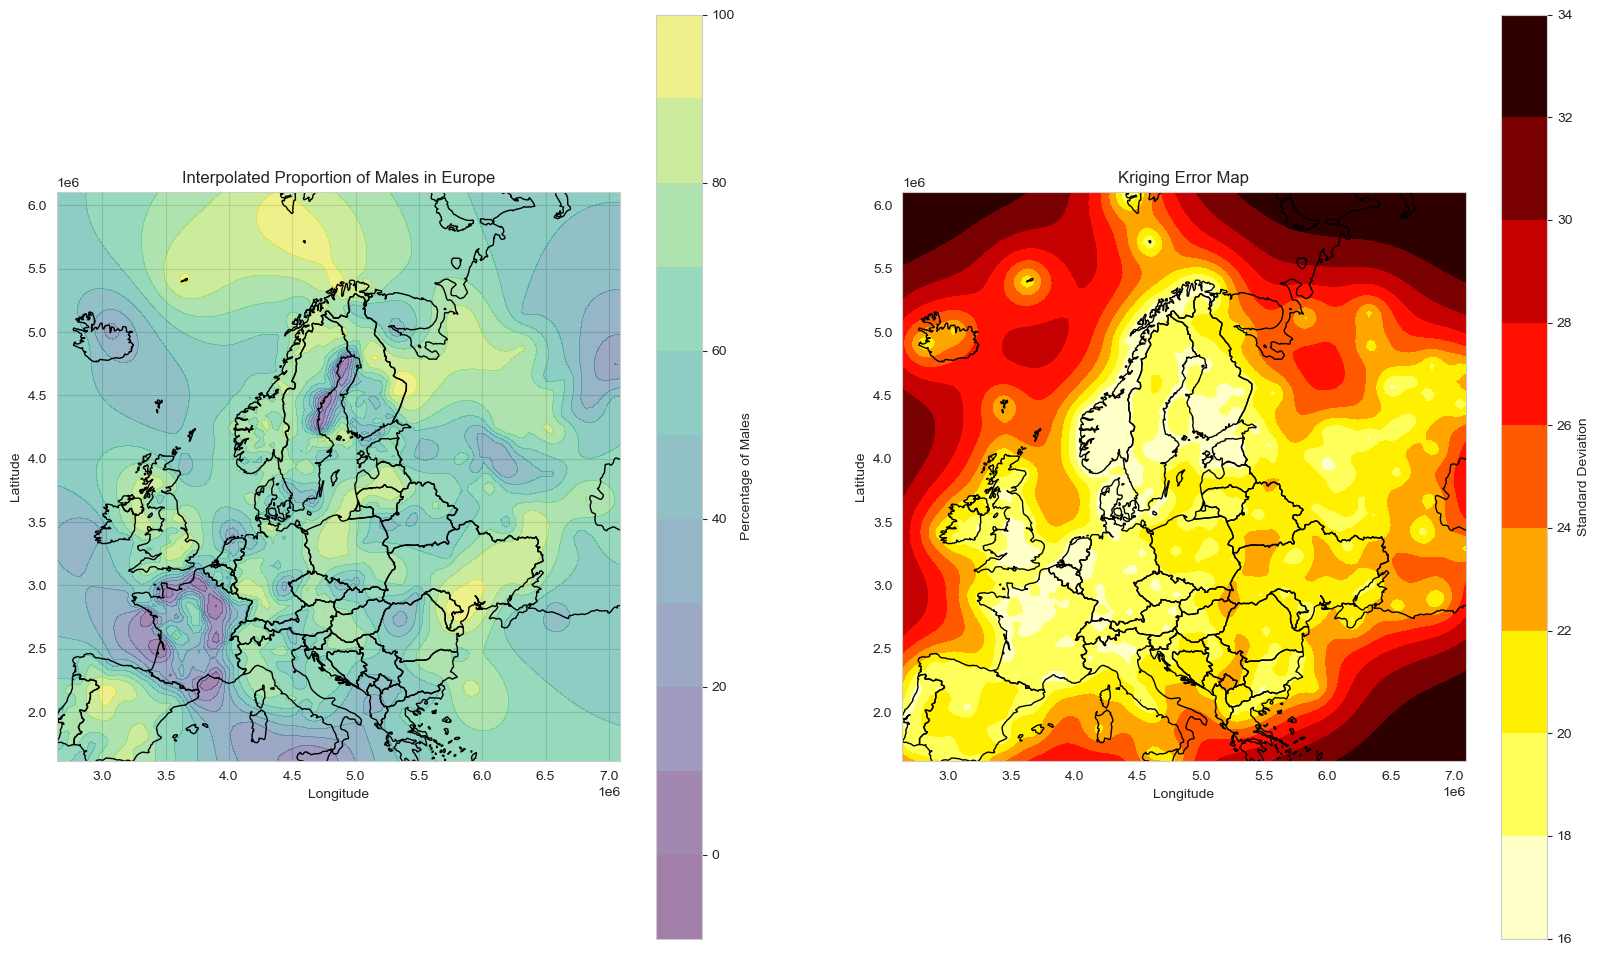

In [204]:
# Assuming these are predefined
# X, Y, z, ss, coordinates, europe

# Set up the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))  # Two subplots side by side

# Plot interpolated data on the first subplot
cf1 = ax1.contourf(X, Y, z, cmap='viridis', alpha=0.5, levels=10, vmin=0, vmax=100)
fig.colorbar(cf1, ax=ax1, label='Percentage of Males')
#ax1.scatter(coordinates[:, 0], coordinates[:, 1], c='black', s=1, label='Sample Points')
europe.boundary.plot(ax=ax1, linewidth=1, edgecolor='k')
ax1.set_title('Interpolated Proportion of Males in Europe')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_aspect('equal')  # Equal aspect ratio

# Plot the error (standard deviation or variance) on the second subplot
# Use the reversed 'hot' colormap
cf2 = ax2.contourf(X, Y, np.sqrt(ss), cmap='hot_r', levels=10)  # '_r' reverses the colormap
fig.colorbar(cf2, ax=ax2, label='Standard Deviation')
#ax2.scatter(coordinates[:, 0], coordinates[:, 1], c='black', s=1, label='Sample Points')
europe.boundary.plot(ax=ax2, linewidth=1, edgecolor='k')
ax2.set_title('Kriging Error Map')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_aspect('equal')  # Equal aspect ratio

# Optionally set the limits for a closer view or to focus on a specific area
ax1.set_xlim([X.min(), X.max()])
ax1.set_ylim([Y.min(), Y.max()])
ax2.set_xlim([X.min(), X.max()])
ax2.set_ylim([Y.min(), Y.max()])

# Save and show the plot
plt.savefig('european_males_interpolation_and_error.jpg', dpi=600, format='jpg')
plt.show()


